# Neural Optimal Control

The goal of this notebook is to solve the optimal control problem by finding eigenfunctions of the operator $\mathcal{K} = \mathcal{L} + \mathcal{R}$ using the neural network approach.

## Imports

In [14]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# Get the parent directory (one level above)
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import math

from tqdm import tqdm

from src.energy.quadratic import QuadraticEnergy

from src.eigensolver.neural.network.feedforward import FeedForwardNetwork, ConstantFFN, ConstantLinearFFN

## Exact solution

We first implement the exact eigenfunctions (see <code>optimalcontrol.ipynb</code>)

In [5]:
def compute_D(A,P,lmbda):
    assert torch.allclose(A, torch.eye(A.shape[0],device=A.device)*A[0,0])
    Lambda, U = torch.linalg.eigh(P)

    a = torch.diag(A)
    sign = torch.where(a > 0, 1.0, -1.0)
    kappa = torch.diag(A) / lmbda * (1 + sign * torch.sqrt(1 + 2 / a**2 * Lambda))

    return U @ torch.diag(kappa) @ U.T

def exact_eigfunctions(x, m, params, return_grad = False):
    """
    Evaluate first m exact eigenfunctions of K at points x
    Args:
        x (tensor)[n,d]: evaluation points
        m (int): number of eigenfunctions to compute
        params (dict): problem parameters
        return_grad (bool): whether to return gradient
    Returns:
        fx (tensor)[n,m]: first m eigenfunction evaluations
        (Optinal) grad_fx (tensor)[n,m,d]: gradients of first m eigenfunctions
    """
    A = params['A']
    P = params['P']
    dim = A.shape[0]
    lmbda = params['lmbda']

    D = compute_D(A, P, lmbda)
    energy = QuadraticEnergy(-2/lmbda * A + 2*D)

    normalizer = ((2*math.pi)**(dim/2) / torch.linalg.det(-2/lmbda * A + 2 * D) ** (1/2)) ** (1/2)
    quadratic_form = torch.exp(- 1/2 * torch.einsum('ij, ij -> i',x @ D, x))
    
    if return_grad:
        wx, grad_wx = energy.exact_eigfunctions(x, m, use_scipy=False, return_grad=True)
        fx = wx * quadratic_form[:,None] / normalizer
        grad_fx = (grad_wx - (x @ D.T)[:,None,:] * wx[:,:,None]) * quadratic_form[:, None, None] / normalizer

        return fx, grad_fx
    
    else:
        wx = energy.exact_eigfunctions(x, m, use_scipy=False)
        fx = wx * quadratic_form[:,None] / normalizer
        
        return fx

def exact_eigvals(k, params, shift = False):
    """
    Compute m smallest exact eigenvalues of K
    Args:
        m (Int)
        shift (bool): whether to include constant shift
    Returns:
        eigvals (tensor)
    """
    lmbda = params['lmbda']
    
    A = params['A']
    P = params['P']

    D = compute_D(A, P, lmbda)
    
    energy = QuadraticEnergy(-2/lmbda * A + 2*D)
    
    if shift:
        eigvals = lmbda/2 * (energy.exact_eigvals(k) + torch.trace(D))
    else:
        eigvals = lmbda/2 * (energy.exact_eigvals(k))

    return eigvals

In [6]:
dim = 1
A = torch.eye(dim) * 0.2
P = torch.eye(dim) * 0.2
Q = torch.eye(dim) * 0.1
sigma = torch.eye(dim)
lmbda = 1

params = {'A': A, 'P': P, 'Q': Q, 'sigma': sigma, 'lmbda': lmbda}

D = compute_D(A, P, lmbda)

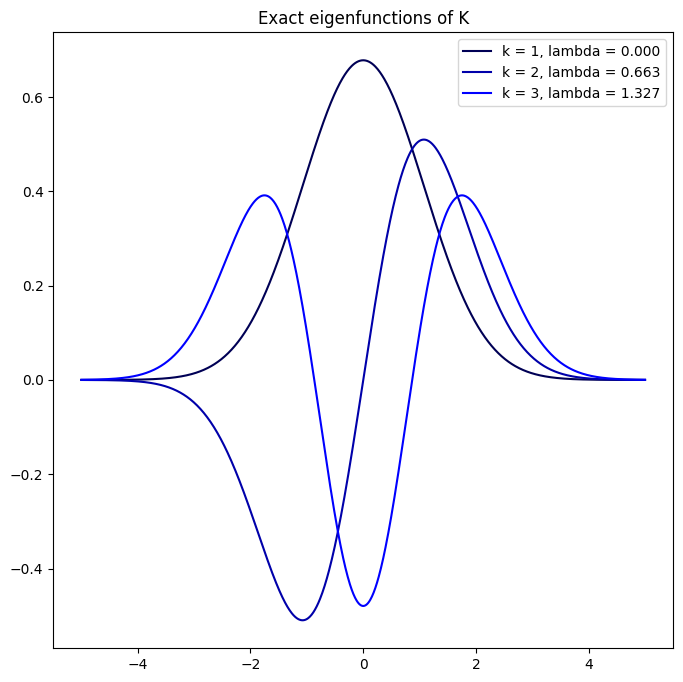

In [8]:
x = torch.linspace(-5, 5,1000)[:,None]

k = 3
fig, ax = plt.subplots(figsize=(8,8))
blue_colors = [(0, 0, (i / k)) for i in range(1, k + 1)]  # RGB: (Red, Green, Blue)
red_colors = [((i / k),0,0) for i in range(1, k + 1)]  # RGB: (Red, Green, Blue)


fx, grad_fx = exact_eigfunctions(x,k, params, return_grad=True)
eigvals = exact_eigvals(k, params)
for i in range(k):
    ax.plot(x, fx[:,i], color = blue_colors[i], label = f'k = {i+1}, lambda = {eigvals[i]:.3f}')

ax.set_title('Exact eigenfunctions of K')
plt.legend()

## Loss function

In [15]:
def R_func(x, params):
    """
    The function R in Kf = Lf + Rf.
    Args:
        x (tensor)[N,d]: input values
        params (dict): problem parameters
    Returns:
        Rx (tensor)[N]: output values
    """
    return 1/params['lmbda'] * torch.einsum('ij, ij -> i',x @ params['P'], x)

We first try to compute the first eigenfunction, which is done by using the loss function
$$R(f) = \frac{<f, \mathcal{K}f>_\mu}{<f, f>_\mu} = \frac{<\nabla f, \nabla f>_\mu + <f, Rf>_\mu}{<f, f>_\mu}$$

In [11]:
def ritz_loss(fx, grad_fx, Rx):
    """
    Args:
        fx (tensor)[B]: output evaluated at batch of samples
        grad_fx (tensor)[B,d]: gradient of output evaluated at batch of samples
        Rx (tensor)[B]: R evaluated at batch of samples
    Returns:
        loss (tensor)
    """

    norm = torch.mean(fx**2)
    grad_norm = torch.mean(torch.norm(grad_fx,dim=1)**2)
    R_norm = torch.mean(fx**2 * Rx)

    return (R_norm + grad_norm) / norm

def compute_loss(model, x, params):
    """
    Compute loss of the model give samples x
    Args:
        Modle (nn.Module): model
        x (torch.tensor): samples
        params (problem parameters)
    Returns:
        loss (tensor)
    """
    fx = model(x)
    Rx = R_func(x, params)
    grad_fx = torch.autograd.grad(outputs = fx[0], inputs = x, create_graph=True)[0]



In [17]:
dim = 3
k = 1
model = FeedForwardNetwork([dim,50,50,k])

optimizer = optim.Adam(model.parameters(), lr = 1.0)

In [30]:
x = torch.randn((10000,dim),requires_grad=True)
fx = model(x)

In [32]:
grad_fx = torch.autograd.grad(outputs = fx[0], inputs = x)[0]

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.